# PHYS Advanced Lab #1

In [22]:
import numpy as np
import pandas as pd

import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact, fixed
from scipy.integrate import odeint
from scipy.optimize import curve_fit

### Loading our data (iPhone + Tracker software)

In [50]:
# Load csv data into dataframe
df = pd.read_csv('phys_lab1.csv')

# Remove all datapoints before finger release (and reset index as well)
df = df[8:].reset_index(drop = True)

# Reset t = 0
df['t'] = df['t'] - df['t'][0]

# Convert z to cm, to be consistent with sample data
df['z'] = df['z']*100

# Set y(0) = 0
#df['z'] = df['z'] - df['z'][0] 

df.head()

,t,z
0,0.000000,-6.559419
1,0.033333,-4.927616
2,0.066667,-3.381697
3,0.100000,-1.685481
4,0.133333,-0.246918


### Loading sample data (provided by Dr. Smith)

In [51]:
# Loading from dat file
file_dir = './'
filename= '7924.dat'

data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
z_data = data[:,2]/10 # bc in mm

In [52]:
# Convert to dataframes (personal preference)
df1 = pd.DataFrame()
df1['t'] = time_data
df1['z'] = z_data

# Remove all datapoints before finger release (reset index as well)
df1 = df1[8:].reset_index(drop = True)

# Reset t = 0
df1['t'] = df1['t'] - df1['t'][0]

# Set y(0) = 0
#df1['z'] = df1['z'] - df1['z'][0] 

df1.head()

,t,z
0,0.000000,-9.198580
1,0.033333,-7.202462
2,0.066667,-3.770063
3,0.100000,-1.618412
4,0.133333,0.175949


#### Plotting both datasets

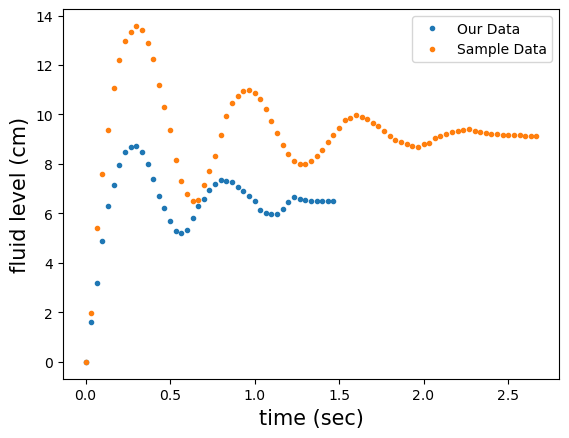

In [53]:
# Note: for these plots set z(0) = 0 
plt.plot(df['t'],df['z'] - df['z'][0],'.', label='Our Data')
plt.plot(df1['t'],df1['z'] - df1['z'][0],'.', label='Sample Data')
plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.legend()

plt.show()

In [54]:
# Put interactive code into standalone python file to keep things clean
from support_code import plot_osc

In [55]:
interact(plot_osc, df = fixed(df), h=(0.0, 20.0),g=(5.0e2, 15.0e2),b=(0.0, 30.0));

interactive(children=(FloatSlider(value=10.0, description='h', max=20.0), FloatSlider(value=980.0, description…

In [58]:
interact(plot_osc, df = fixed(df1), h=(0.0, 20.0),g=(5.0e2, 15.0e2),b=(0.0, 30.0));

interactive(children=(FloatSlider(value=10.0, description='h', max=20.0), FloatSlider(value=980.0, description…

/opt/homebrew/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Power Spectrum of Straw Oscillations')

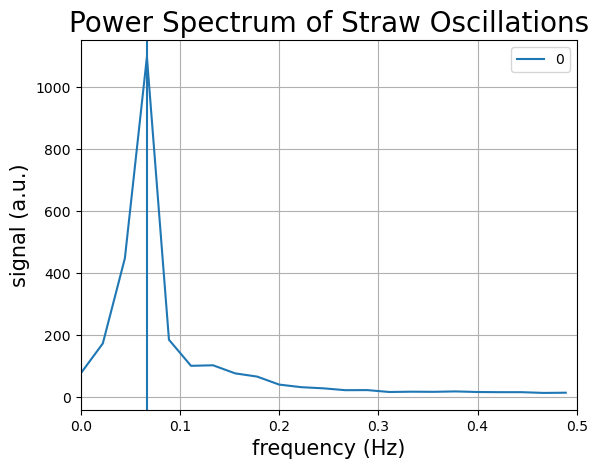

In [91]:
Y_FFT = np.fft.rfft(df['z'])
fft_power = pd.DataFrame(Y_FFT * np.conjugate(Y_FFT))

DT = df.index[1]-df.index[0]   # sample time
fft_power.index=(np.fft.fftfreq(df['z'].shape[0])/DT)[0:len(fft_power)]
fft_power.plot()
plt.xlim([0,.5])

title = 'Power Spectrum of Straw Oscillations'
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'
plt.axvline(x=.067)
plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.grid()
plt.title(title,fontsize=20)

In [98]:
f = (1/2*np.pi)*(9.80/10.2)**.5
print(f,'Hz')

1.539688368732673 Hz


/opt/homebrew/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Power Spectrum of Straw Oscillations')

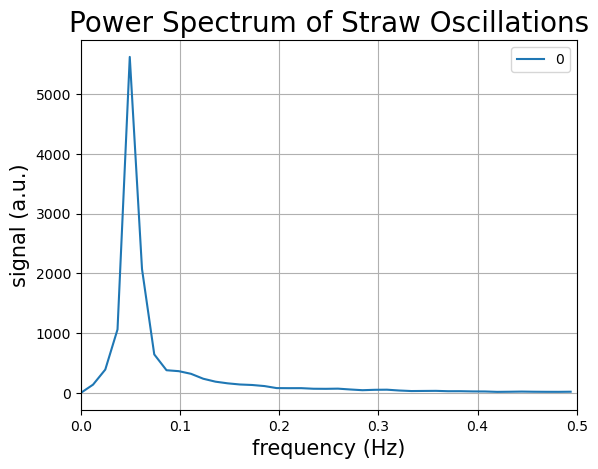

In [78]:
Y_FFT1 = np.fft.rfft(df1['z'])
fft_power1 = pd.DataFrame(Y_FFT1 * np.conjugate(Y_FFT1))

DT = df1.index[1]-df1.index[0]   # sample time
fft_power1.index=(np.fft.fftfreq(df1['z'].shape[0])/DT)[0:len(fft_power1)]
fft_power1.plot()
plt.xlim([0,.5])

title = 'Power Spectrum of Straw Oscillations'
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'

plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.grid()
plt.title(title,fontsize=20)

In [23]:
# Solving the Newton's law model and also equations 17a and 17b from Lorenceau paper:

# Newton's law model
def DZ_dt_Newton(Z, t, args):
    h = args[0]
    g = args[1]
    b = args[2]
    return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0] ]

# Lorenceau model:
def DZ_dt_Lor(Z, t, args):
    h = args[0]
    g = args[1]
    Omeg = args[3]
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1] ]


def plot_osc(df,h=10.0, g=9.8e2,b = 23,factor=2.60):

    # prepare data for plotting:
    z_data1 = df['z']+h # change the overall level so that bottom of straw is z=0
    time_axis1 = df['t']  # only include data for positive times (after cap is released)
    
    # prepare parameters for solving models:
    Omeg = 0.062*factor
    params = (h,g,b,Omeg)    
    
    # solve Newton model:
    t_soln = time_axis1
    Z_soln_Newton = sp.integrate.odeint(DZ_dt_Newton, [0.02, 0], t_soln, args=(params,))   

    z_soln_Newton = Z_soln_Newton[:,0]      # fluid height
#     ydot_soln_Newton = Y_soln_Newton[:,1]   # fluid velocity

    # solve Lorenceau model, equation 17a and 17b....
    t_solnLor = np.arange(0, 30, 0.01)
    Z_soln_Lor = sp.integrate.odeint(DZ_dt_Lor, [0.02, 0.00], t_solnLor, args=(params,))   
    
    z_soln_Lor = Z_soln_Lor[:,0]*h       # fluid height

    Omeg = 0.062*factor
    params = (h,g,b,Omeg)

    plt.clf()
    plt.plot(time_axis1,z_data1,'b.',label='Data') 
    plt.plot(t_soln,z_soln_Newton,'r',label='Newtonian model')

    plt.xlabel('time (sec)',fontsize=15)
    plt.ylabel('fluid level (cm)',fontsize=15)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)

    plt.plot(t_solnLor*(h*1e-2/9.8)**0.5,z_soln_Lor,'g--',label='Lorenceau model')
    plt.title('Fluid level oscillations with both models\nOmega=%2.2e (no unit), h=%2.2f, b=%2.2e\nfilename = %s'%(Omeg,h,b,filename),fontsize=15)
    plt.legend(frameon=False,loc=1)
    plt.xlim([-0.2,3])
    plt.grid()
#     plt.savefig('fluid oscillation with fits.png',dpi=400)
    plt.show()
   
interact(plot_osc, df = fixed(df), h=(0.0, 20.0),g=(5.0e2, 15.0e2),b=(0.0, 30.0));

interactive(children=(FloatSlider(value=10.0, description='h', max=20.0), FloatSlider(value=980.0, description…